# Building a time series meta forecasting model with Prophet and LSTM
PyData 2021 Lightning Talk

https://github.com/sonalake/prophet-lstm-pydata-2021

## Challenge
Mobile telecommunications operators face congestion issues in their networks due to increased usage and environmental factors. As cellular base station congestion negatively impacts customer experience, it can negatively also impact revenue and increase subscriber churn. This notebook demonstrates using time series forecasting to predict network congestion so that the operators are better equipped to manage the situation proactively.

##  Workflow, Data Preprocessing and Pipeline

- Fit a [Prophet](https://facebook.github.io/prophet/) model on our training data
- Extract what Prophet has learned and use it to improve the training process of an [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) model, thus performing two-step training

In [5]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from kerashypetune import KerasGridSearch, KerasGridSearchCV
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
register_matplotlib_converters()

In [6]:
DAY = 0
WEEK = 1
MONTH = 2
WEEK2 = 3

predict_interval = MONTH
# predict_interval = WEEK
# predict_interval = DAY
# predict_interval = WEEK2

In [7]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(33)

In [8]:
sales = pd.read_csv('SC_201807_202207.csv', usecols=['RepCust', 'ScDate', 'BU','Qty','NetUPrice','ScId'])
sales = sales[(sales['ScDate']<='2022-06-30')]
sales['ScDate'] = pd.to_datetime(sales['ScDate'])
PRESENT = datetime.datetime(2022,7,1)

In [9]:
# start = datetime.datetime.strptime('2018-06-01', '%Y-%m-%d')
# end_train = datetime.datetime.strptime('2022-05-30', '%Y-%m-%d')
# end_test = datetime.datetime.strptime('2022-06-30', '%Y-%m-%d')

start = datetime.datetime.strptime('2020-06-01', '%Y-%m-%d')
end_train = datetime.datetime.strptime('2022-05-30', '%Y-%m-%d')
end_test = datetime.datetime.strptime('2022-06-30', '%Y-%m-%d')

# start = datetime.datetime.strptime('2021-05-01', '%Y-%m-%d')
# end_train = datetime.datetime.strptime('2022-05-30', '%Y-%m-%d')
# end_test = datetime.datetime.strptime('2022-06-30', '%Y-%m-%d')

# start = datetime.datetime.strptime('2018-06-01', '%Y-%m-%d')
# end_train = datetime.datetime.strptime('2022-05-30', '%Y-%m-%d')
# end_test = datetime.datetime.strptime('2022-06-30', '%Y-%m-%d')

# start = datetime.datetime.strptime('2020-05-01', '%Y-%m-%d')
# end_train = datetime.datetime.strptime('2022-04-30', '%Y-%m-%d')
# end_test = datetime.datetime.strptime('2022-05-30', '%Y-%m-%d')

# start = datetime.datetime.strptime('2021-06-01', '%Y-%m-%d')
# end_train = datetime.datetime.strptime('2022-05-30', '%Y-%m-%d')
# end_test = datetime.datetime.strptime('2022-06-30', '%Y-%m-%d')

## RFM

In [10]:
sales1 = sales[['RepCust','ScDate','Qty','ScId']]

sales1 = sales1.loc[(sales['ScDate'] >= start) & (sales['ScDate'] <= end_test)]

rfm = sales1.groupby('RepCust').agg({
    'ScDate': lambda date: (PRESENT - date.max()).days,
    'ScId': lambda num: len(num),
    'Qty': lambda price: price.sum(),
})
rfm.columns=['recency','frequency','monetary']
rfm['recency']=rfm['recency'].astype(int)
rfm['r_quartile'] = pd.qcut(rfm['recency'], 5, ['1','2','3','4','5'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 5, ['1','2','3','4','5'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 5, ['1','2','3','4','5'])
rfm['RFM_Score']= rfm.r_quartile.astype(str) + rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfmfilter = rfm[(rfm['f_quartile']>='5')].reset_index()

In [11]:
rfmfilter

,RepCust,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
0,Applied DB,23,46,4494.000,2,5,5,255
1,BINA,28,55,1265.000,2,5,4,254
2,Dat Hoa,30,55,1104.000,2,5,4,254
3,HSING(M),3,85,6814.925,1,5,5,155
4,LUCKY UNION,14,235,2943.720,1,5,5,155
...,...,...,...,...,...,...,...,...
345,麗隆達沈陽,22,45,1590.000,2,5,4,254
346,鼎信東莞,23,53,4150.000,2,5,5,255
347,龍塑佛山,10,70,4964.150,1,5,5,155
348,龍宮河北,15,56,1984.000,1,5,5,155


In [12]:
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
RepCust,,,,,,,
3H-VN,61,20,618.00,3,4,4,344
3M,22,38,381.00,2,4,3,243
ALLIED,2,37,2253.00,1,4,5,145
ALPHA,134,1,12.00,4,1,1,411
AMERSEAL,241,3,7.80,4,1,1,411
...,...,...,...,...,...,...,...
龍塑佛山,10,70,4964.15,1,5,5,155
龍宮河北,15,56,1984.00,1,5,5,155
龍崗河北,263,46,1792.00,4,5,5,455


In [13]:
low, high = rfm['frequency'].quantile(0.05), rfm['frequency'].quantile(0.95)
print(low, high)
r = rfm.loc[(rfm['frequency'] > low) & (rfm['frequency'] < high)]

display(rfm.describe())
display(r.describe())

rfm = r

1.0 105.39999999999986


,recency,frequency,monetary
count,1773.000000,1773.000000,1773.000000
mean,143.926678,28.623237,1392.212715
std,161.375836,49.640027,3938.839960
min,1.000000,1.000000,0.040000
25%,22.000000,4.000000,64.000000
50%,61.000000,12.000000,295.000000
75%,235.000000,34.000000,1162.000000
max,760.000000,1129.000000,98307.600000


,recency,frequency,monetary
count,1520.000000,1520.000000,1520.000000
mean,132.835526,22.686842,931.779509
std,151.678237,23.545859,1507.577898
min,1.000000,2.000000,0.040000
25%,22.000000,5.000000,96.000000
50%,61.000000,13.000000,323.500000
75%,205.000000,32.000000,1091.787500
max,651.000000,105.000000,14676.000000


In [14]:
# s = sales1
# low, high = s['Qty'].quantile(0.05), s['Qty'].quantile(0.95)
# print(low, high)
# r = s.loc[(s['Qty'] > low) & (s['Qty'] < high)]
# sales1 = r

In [15]:
rows = sales1.RepCust.isin(rfmfilter.RepCust)
sales1 = sales1[rows]
#sales1= sales1[sales1['ScDate']<'2021-12-31']

In [16]:
sales2 = sales1.groupby(['ScDate'])['Qty'].sum().reset_index()
sales2

,ScDate,Qty
0,2020-06-01,22213.89
1,2020-06-02,6360.91
2,2020-06-03,4606.05
3,2020-06-04,2246.00
4,2020-06-05,2497.70
...,...,...
586,2022-06-23,1246.00
587,2022-06-24,1507.80
588,2022-06-27,1082.79
589,2022-06-28,847.80


In [17]:
dates = pd.date_range(sales2['ScDate'].min(), sales2['ScDate'].max())
sales3 = (sales2.set_index(['ScDate'])
      .reindex(dates)
      .rename_axis(['ds'])
      .fillna(0)
      .reset_index())

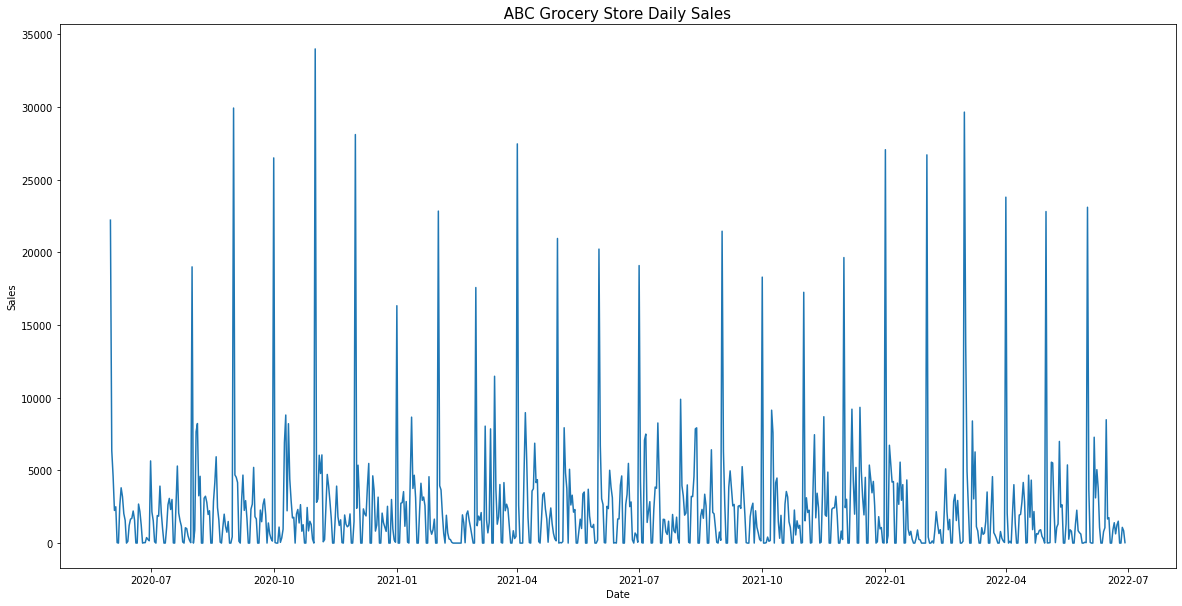

In [18]:
# %matplotlib qt
%matplotlib inline

sales3.columns = ['ds','y']
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="ds", y="y", data=sales3)
ax.set(xlabel='Date', ylabel='Sales')
ax.set_title(" ABC Grocery Store Daily Sales ",fontsize=15)
plt.show()

## Preprocess

In [19]:
def date_periods(df, label=None):
    df = df.copy()

    df['date'] = df.ds
    df['weekofyear'] = df['ds'].dt.strftime('%W')
    df['month'] = df['ds'].dt.strftime('%B')
    df['year'] = df['ds'].dt.strftime('%Y')
    df['dayofweek'] = df['ds'].dt.strftime('%A')
    df['quarter'] = df['ds'].dt.quarter
        
    X = df[['dayofweek','month','quarter','year']]
    if label:
        y = df[label]
        return X, y
    return X

In [20]:
def fft_plot(temp:pd.DataFrame, do_show=False):
    # %matplotlib inline
    %matplotlib qt
    real = temp['y'].tolist()
    f = np.fft.fft(real)
    f_mag = np.abs(f) / len(real)

    # Construct a time signal
    Fs = 1  # Sampling freq
    tstep = 1 / Fs  # sample time interval
    # f0 = 100  # signal freq

    N = len(real) # int(Fs / f0) * 10  # number of samples

    t = np.linspace(0, (N - 1) * tstep, N)  # time steps
    fstep = Fs / N  # frequency interval
    f = np.linspace(0, (N - 1) * fstep, N)  # freq steps

    y = real # 1 * np.sin(2 * np.pi * f0 * t) + 4 * np.sin(2 * np.pi * 3 * f0 * t)

    # perform fft
    X = np.fft.fft(y)
    X_mag = np.abs(X) / len(y)

    f_plot = f[0:N // 2 + 1]
    f_plot = [1/c for c in f_plot]
    X_mag_plot = 2 * X_mag[0:N // 2 + 1]
    X_mag_plot[0] = X_mag_plot[0] / 2  # Note: DC component does not need to multiply by 2

    # plot
    if do_show:
        fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
        ax2:plt.Axes
        ax1.set_title('day vs Qty')
        ax1.plot(t, y, '.-')
        ax2.set_title('Period (days)')
        ax2.plot(f_plot, X_mag_plot, '.-')
        plt.show()

    r = [(xm, fp) for fp, xm in zip(f_plot, X_mag_plot)]
    r.sort()
    
    return r

In [21]:
# same as run_final_model, but separate seaon and order

def run_final_model2(train, season=[(20, 30.5), (20, 15)]):
    final_model2 = Prophet(
        changepoint_prior_scale= 0.1,
        holidays_prior_scale = 0.5,
        n_changepoints = 100,
        interval_width=0.95, growth = 'logistic'
    )
    final_model2.add_country_holidays(country_name='CN')
    for order, s in season:
        final_model2.add_seasonality(name=str(s), period=s, fourier_order=order)
    final_model2.fit(train)
    return final_model2

# final_model2 = run_final_model2(final_train, season=[(20, s) for s in [2.3, 2.7, 2.5, 7.0, 6.0, 7.5, 10.1, 15.1, 30.3]])

In [22]:
def get_error(y1, y2):
    mse = round(np.sqrt(mean_squared_error(y1, y2)), 2)
    mae = round(mean_absolute_error(y1, y2), 2)
    return mse, mae

In [23]:
# separate data of each customer

def date_range(start, end):
    r = (end+datetime.timedelta(days=1)-start).days
    return [start+datetime.timedelta(days=i) for i in range(r)]
    
customers = sales1['RepCust'].unique().tolist()
max_month = sales1['ScDate'].max()
min_month = sales1['ScDate'].min()
# min_month = datetime.datetime.strptime('2020-07-01', '%Y-%m-%d')

frames = []

for cus in customers:
    cus_df = sales1.loc[sales1['RepCust'] == cus][['ScDate', 'Qty']]
    cus_df = cus_df.groupby(['ScDate']).agg({'Qty': np.sum}).reset_index()
    # min_month = cus_df['ScDate'].min()

    frame = pd.DataFrame(date_range(min_month, max_month), columns=['ScDate'])
    frame['RepCust'] = cus
    frame = frame.merge(cus_df, on=['ScDate'], how='left')
    frame = frame.fillna(0)
    frames.append(frame)

df_frame = pd.concat(frames)

# df_frame = sales1[['ScDate', 'RepCust', 'Qty']]

# display(sales1)
display(df_frame)

,ScDate,RepCust,Qty
0,2020-06-01,無錫國豐,616.2
1,2020-06-02,無錫國豐,0.0
2,2020-06-03,無錫國豐,0.0
3,2020-06-04,無錫國豐,0.0
4,2020-06-05,無錫國豐,0.0
...,...,...,...
754,2022-06-25,Applied DB,0.0
755,2022-06-26,Applied DB,0.0
756,2022-06-27,Applied DB,0.0
757,2022-06-28,Applied DB,0.0


In [24]:
df_frame_bk = df_frame.copy(deep=True)

In [25]:
df_frame = df_frame_bk.copy(deep=True)

df_frame_no_filter = df_frame.copy(deep=True)

def condense_month(df):
    df['year'] = df['ScDate'].dt.strftime('%Y')
    df['month'] = df['ScDate'].dt.strftime('%m')

    df = df.groupby(['RepCust', 'year', 'month']).agg({
        'ScDate': np.min,
        'Qty': np.sum,
    }).reset_index()
    return df[['ScDate', 'RepCust', 'Qty', ]]

if predict_interval == MONTH:
    df_frame = condense_month(df_frame)
    df_frame_no_filter = condense_month(df_frame_no_filter)

elif predict_interval == WEEK:
    filtered = []
    for cus in df_frame['RepCust'].unique():
        cus_d = df_frame.loc[df_frame['RepCust'] == cus]
        # d = cus_d.rolling(window=7, win_type='gaussian', center=True).mean(std=0.5)
        d = cus_d.rolling(window=11, center=False).mean(std=0.5)
        cus_d['Qty'] = d
        filtered.append(cus_d)

    df_frame = pd.concat(filtered)
    df_frame = df_frame.dropna()
    
    def condense_week(df):
        df['year'] = df['ScDate'].dt.strftime('%Y')
        df['week'] = df['ScDate'].dt.strftime('%W')

        df = df.groupby(['RepCust', 'year', 'week']).agg({
            'ScDate': np.min,
            'Qty': np.sum,
        }).reset_index()

        df = df[['ScDate', 'RepCust', 'Qty', ]]
        return df
    
    df_frame = condense_week(df_frame)
    df_frame_no_filter = condense_week(df_frame_no_filter)
elif predict_interval == WEEK2:
    filtered = []
    for cus in df_frame['RepCust'].unique():
        cus_d = df_frame.loc[df_frame['RepCust'] == cus]
        # d = cus_d.rolling(window=7, win_type='gaussian', center=True).mean(std=0.5)
        d = cus_d.rolling(window=7, center=False).mean(std=0.5)
        cus_d['Qty'] = d
        filtered.append(cus_d)

    df_frame = pd.concat(filtered)
    df_frame = df_frame.dropna()
    
    def condense_week2(df):
        df['year'] = df['ScDate'].dt.strftime('%Y')
        df['week'] = df['ScDate'].dt.strftime('%W').astype(int)
        df['week'] = df['week'].apply(lambda x: x / 2)

        df = df.groupby(['RepCust', 'year', 'week']).agg({
            'ScDate': np.min,
            'Qty': np.sum,
        }).reset_index()

        df = df[['ScDate', 'RepCust', 'Qty', ]]
        return df
    
    df_frame = condense_week2(df_frame)
    df_frame_no_filter = condense_week2(df_frame_no_filter)
elif predict_interval == DAY:
    pass



In [26]:
# %matplotlib qt

# row, col = 1, 1
# f, axs = plt.subplots(figsize=(22,5), nrows=row, ncols=col)

# # axlist = [axs[i][j] for i in range(row) for j in range(col)]
# axlist = [axs]

# start_cus = 10
# for ax, cus in zip(axlist, customers[start_cus:start_cus + row * col]):
#     r = df_frame_bk[df_frame_bk['RepCust'] == cus]
#     r.plot(kind='line',x='ScDate', y='Qty', color='green', label='Actual', ax=ax)
#     r = df_frame[df_frame['RepCust'] == cus]
#     r.plot(kind='line',x='ScDate', y='Qty', color='blue', label='Smooth', ax=ax)

# plt.legend()
# plt.show()

## Train

In [27]:
df_frame

,ScDate,RepCust,Qty
0,2020-06-01,Applied DB,0.0
1,2020-07-01,Applied DB,210.0
2,2020-08-01,Applied DB,0.0
3,2020-09-01,Applied DB,420.0
4,2020-10-01,Applied DB,0.0
...,...,...,...
8745,2022-02-01,龍崗河北,0.0
8746,2022-03-01,龍崗河北,0.0
8747,2022-04-01,龍崗河北,0.0
8748,2022-05-01,龍崗河北,0.0


In [29]:
# train/predict/plot single customer data

from tqdm.contrib.concurrent import process_map
# from prophet_util import train_df

freq_count = 10

pred_result_list = []
cus_count = 6

df_frame.columns = ['ds', 'RepCust', 'y']
df_frame_no_filter.columns = ['ds', 'RepCust', 'y']

# ip = [[df_frame, cus, start, end_train, end_test] for cus in customers[:cus_count]]
# pred_result_list = process_map(train_df, ip, max_workers=3)

for cus in tqdm(customers[:cus_count], desc='training each customer'):
    cus_data = df_frame[df_frame['RepCust'] == cus]
    cus_data = cus_data[['ds', 'y', ]]

    cus_data['floor'] = 0
    cus_data['cap'] = 10000
    train = cus_data[(cus_data['ds'] >= start) & (cus_data['ds'] <= end_train)]
    test  = cus_data[(cus_data['ds'] >= start) & (cus_data['ds'] <= end_test)]

    month_day = 30.42
    week_day = 7

    if predict_interval == DAY:
        season = [(50, f[1]) for f in fft_plot(test, False)[-freq_count:-1]]
        # season = [(200, s) for s in [14, 2, 15.25, 7, ]] + [(200, s) for s in [30.42, ]]
        # season = [(10, s) for s in [14, 2, 15.25, 7, ]] + [(10, s) for s in [30.42, ]]
    elif predict_interval == MONTH:
        season = [(2, s) for s in [month_day * 2, month_day * 3, month_day*5]]
    elif predict_interval == WEEK or predict_interval == WEEK2:
        # season = [(50, s) for s in [2, 3, 5]]
        season = [(20, s) for s in [week_day * 2, week_day * 3, week_day * 4]]
        # season = [(200, s) for s in [28.84, 22, 25.75, 80, 45, 17.2, 14.42, 15, 30, ]]
    else:
        raise Exception()
    
    # model2 = run_final_model2(train, season=season)

    # f, ax = plt.subplots(figsize=(14,5), nrows=1, ncols=1)
    # train.plot(kind='line',x='ds', y='y', color='green', label='Actual', ax=ax)
    # plt.legend()
    # plt.show()

    model2 = Prophet(
        growth = 'flat',
        changepoint_prior_scale= 0.1,
        holidays_prior_scale = 0.5,
        n_changepoints = 100,
        interval_width=0.95,
    )
    model2.add_country_holidays(country_name='CN')
    for order, s in season:
        model2.add_seasonality(name=str(s), period=s, fourier_order=order, )
    model2.fit(train)

    pred2 = model2.predict(test)

    # model2.plot_components(pred2)

    pred2['RepCust'] = cus
    res = pred2[['RepCust', 'ds', 'yhat']].copy(deep=True)
    res.columns = ['RepCust', 'ds', 'y']
    
    pred_result_list.append(res)

df_pred_all = pd.concat(pred_result_list)


training each customer:   0%|          | 0/6 [00:00<?, ?it/s]11:09:06 - cmdstanpy - INFO - Chain [1] start processing
11:09:07 - cmdstanpy - INFO - Chain [1] done processing
training each customer:  17%|█▋        | 1/6 [00:01<00:09,  1.95s/it]11:09:08 - cmdstanpy - INFO - Chain [1] start processing
11:09:09 - cmdstanpy - INFO - Chain [1] done processing
training each customer:  33%|███▎      | 2/6 [00:05<00:10,  2.67s/it]11:09:12 - cmdstanpy - INFO - Chain [1] start processing
11:09:12 - cmdstanpy - INFO - Chain [1] done processing
training each customer:  50%|█████     | 3/6 [00:07<00:07,  2.44s/it]11:09:14 - cmdstanpy - INFO - Chain [1] start processing
11:09:14 - cmdstanpy - INFO - Chain [1] done processing
training each customer:  67%|██████▋   | 4/6 [00:09<00:04,  2.20s/it]11:09:15 - cmdstanpy - INFO - Chain [1] start processing
11:09:16 - cmdstanpy - INFO - Chain [1] done processing
training each customer:  83%|████████▎ | 5/6 [00:10<00:02,  2.02s/it]11:09:17 - cmdstanpy - INFO -

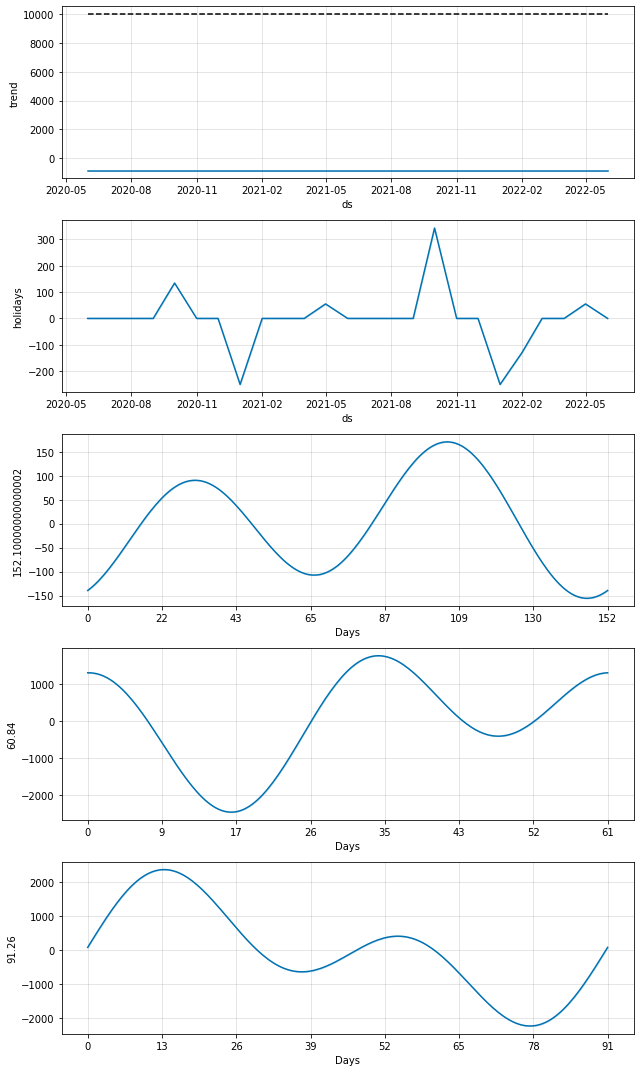

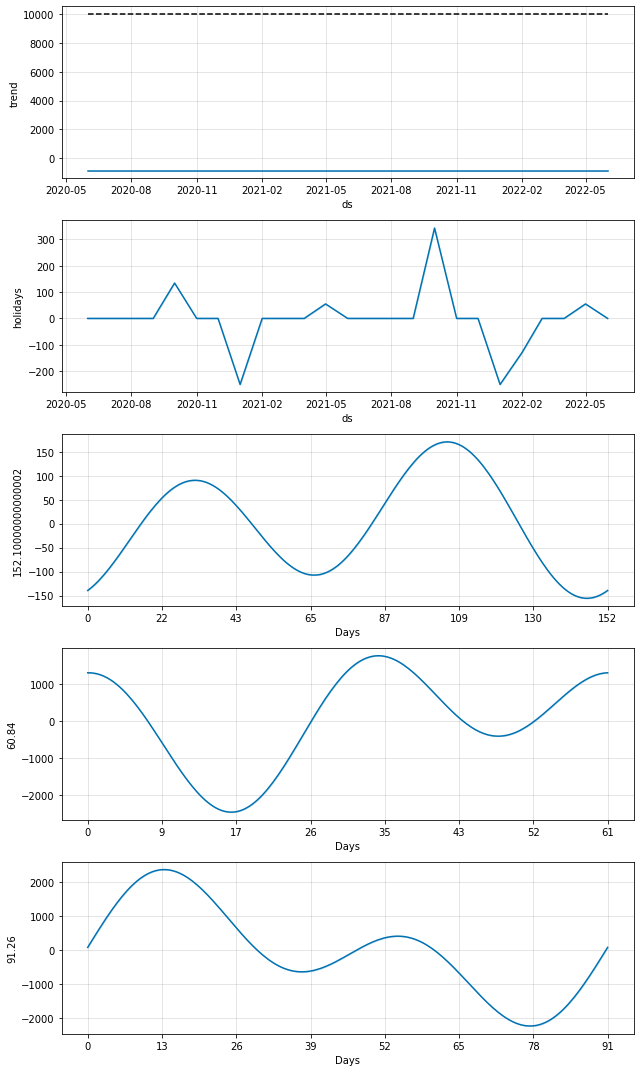

In [30]:
model2.plot_components(pred2)

In [31]:
def condense_month(df:pd.DataFrame):
    df = df[['ds', 'RepCust', 'y', ]]
    df['year'] = df['ds'].dt.strftime('%Y')
    df['month'] = df['ds'].dt.strftime('%m')

    df = df.groupby(['RepCust', 'year', 'month']).agg({
        'ds': np.min,
        'y': np.sum,
    }).reset_index()
    df = df[['ds', 'RepCust', 'y', ]]
    return df

In [32]:
def sum_data(real_data, pred_data, start_date, end_date):
    print(start_date, end_date)
    real = real_data.loc[real_data['RepCust'].isin(customers[:cus_count])]
    real = real.loc[(real['ds'] > start_date) & (real['ds'] <= end_date)]
    real = real.groupby('RepCust').agg({
        'y': np.sum,
    })

    pred = pred_data.loc[pred_data['RepCust'].isin(customers[:cus_count])]
    pred = pred.loc[(pred['ds'] > start_date) & (pred['ds'] <= end_date)]
    pred = pred.groupby('RepCust').agg({
        'y': np.sum,
    })

    return real, pred

# real, pred = sum_data(df_frame, df_pred_all, end_train, end_test)

# real_p, pred_p = sum_data(df_frame, df_pred_all, end_train.replace(day=1) - datetime.timedelta(days=1), end_train)


In [33]:
d = df_frame.loc[df_frame['ds'] < end_train]
d = d.groupby('ds').agg({
    'y': np.sum,
}).reset_index()
days = (d['ds'].iloc[-1] - d['ds'].iloc[0]).days / d.shape[0]

[(pri, per * days) for pri, per in fft_plot(d, False)[-10:]]


c:\Users\eric\Desktop\ML_test\ML_env\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


[(2836.415509570998, 99.85714285714286),
 (4013.486930945352, 699.0),
 (5187.241879819964, 174.75),
 (5484.6313707262825, 349.5),
 (5662.983688701476, 69.9),
 (6224.039190349231, 77.66666666666666),
 (6335.398520329684, 87.375),
 (7281.195324939531, 233.0),
 (8034.2038314972915, 116.5),
 (75780.01166666667, inf)]

In [34]:
%matplotlib qt

df_pred_all['y'].loc[df_pred_all['y'] < 0] = 0

err_start = end_train - datetime.timedelta(days=14)

df_real = df_frame_no_filter.loc[(df_frame_no_filter['ds'] > err_start) & (df_frame_no_filter['ds'] <= end_test)]
# df_real = df_frame.loc[(df_frame['ds'] > err_start) & (df_frame['ds'] <= end_test)]
df_real = df_real[df_real['RepCust'].isin(customers[:cus_count])]
df_real = df_real.sort_values(by=['RepCust', 'ds'])
df_pred = df_pred_all.loc[(df_pred_all['ds'] > err_start) & (df_pred_all['ds'] <= end_test)]
df_pred = df_pred.sort_values(by=['RepCust', 'ds'])

for ds in df_pred['ds'].unique():
    mse, mae = get_error(df_real.loc[df_real['ds'] == ds]['y'], df_pred.loc[df_pred['ds'] == ds]['y'])
    # display(df_real.loc[df_real['ds'] == ds], df_pred.loc[df_pred['ds'] == ds])
    print(ds, 'mse', mse, 'mae', mae)

row, col = 2, 3
f, axs = plt.subplots(figsize=(14,5), nrows=row, ncols=col)

axlist = [axs[i][j] for i in range(row) for j in range(col)]

start_cus = 0
# dp = condense_month(df_pred_all)
# df = condense_month(df_frame)

dp = df_pred_all
df = df_frame

for ax, cus in zip(axlist, customers[start_cus:start_cus + row * col]):
    p = dp[dp['RepCust'] == cus]
    r = df[df['RepCust'] == cus]
    
    r.plot(kind='line',x='ds', y='y', color='green', label='Actual', ax=ax)
    p.plot(kind='line',x='ds',y='y', color='blue',label='Forecast', ax=ax)

plt.legend()
plt.show()

# train = df_pred
# test = 

c:\Users\eric\Desktop\ML_test\ML_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


2022-06-01T00:00:00.000000000 mse 226.33 mae 181.61


In [35]:
df_real_month = condense_month(df_real)
df_pred_month = condense_month(df_pred)

for ds in df_pred_month['ds'].unique():
    mse, mae = get_error(df_real_month.loc[df_real_month['ds'] == ds]['y'], df_pred_month.loc[df_pred_month['ds'] == ds]['y'])
    print(ds, 'mse', mse, 'mae', mae)
    

2022-06-01T00:00:00.000000000 mse 226.33 mae 181.61


c:\Users\eric\Desktop\ML_test\ML_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\eric\Desktop\ML_test\ML_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
r = condense_month(df_real_month)
p = condense_month(df_pred_month)

r['pred'] = p['y']
display(r)

,ds,RepCust,y,pred
0,2022-06-01,南通康輝,384.0,324.560055
1,2022-06-01,南通華能,411.0,289.962392
2,2022-06-01,宣城亞邦,596.0,308.785913
3,2022-06-01,江蘇名陽,966.6,567.882352
4,2022-06-01,無錫國豐,213.8,432.130788
5,2022-06-01,蘇州三菱,70.0,74.938726
